# Clustering: Below-Phoneme

### Plotting

In [10]:
import os, sys


directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from dataset.loading import DataLoader
from lib.plotting.plot_0 import *
from lib.esn import ESN
from lib.clustering.clustering_metrics import *
from experiments.exp2_below_phoneme_clustering.kmeans.method import *
from experiments.exp2_below_phoneme_clustering.kmeans.point import Point
from experiments.exp2_below_phoneme_clustering.kmeans.kmeans import KMeans
from experiments.helpers.experiment_helpers import *

from matplotlib import gridspec
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

SyntaxError: invalid syntax (378781975.py, line 11)

In [7]:
"""
Problem-specific plotting
"""
class Plot:
    def __init__(self, x=10, y=10):
        plt.rcParams["figure.autolayout"] = True
        self.fig = plt.figure(figsize=(y,x))
        self.cnt = 0
        self.new_ax = None

    def add(self, y, label=None):
        if label is not None:
            self.new_ax.plot(y, label=label)
            self.new_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                 ncol = 2, fancybox=True, shadow=True,
                                 handleheight=2.4, labelspacing=0.05)
        else:
            self.new_ax.plot(y)

    def inc(self, ylabel="", xlabel=""):
        """Plots the data to a new subplot at the bottom."""
        self.cnt += 1
        gs = gridspec.GridSpec(self.cnt, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        self.new_ax = self.fig.add_subplot(gs[self.cnt-1])
        self.new_ax.set_xlabel(xlabel, fontsize=16)
        self.new_ax.set_ylabel(ylabel, fontsize=16)
        
        
    def add_new(self, y, label="No Label"):
        self.inc()
        self.add(y, label)

    @staticmethod
    def assignment_to_function_repr(assignment, length):
        y = []
        for idx in range(length):
            if idx in assignment:
                y.append(1)
            else:
                y.append(0)
        return y

    def add_new_assignment_plot(self, assignments, labels=[], smoothness=5, xlabel="", ylabel=""):
        self.inc(ylabel, xlabel)
        length = max( [ max(cluster) for cluster in assignments if cluster ] )
        for idx, assignment in enumerate(assignments):
            y = Plot.assignment_to_function_repr(assignment, length)
            if max(assignment) > 0:
                if labels is None:
                    self.add(smoothed(y,smoothness))
                elif not labels:
                    self.add(smoothed(y, smoothness), idx)
                else:
                    self.add(smoothed(y, smoothness), str(labels[idx]))

    def add_new_conceptors_fit_plot(self, X, Cs, Ns=None, label="", labels="", smoothness=3):
        """
        Plots, for each time step t, how well each conceptor in Cs matches the state x(t)
        """
        self.inc()
        if Ns:
            collection = evidences_for_Cs(X,Cs,Ns)
        else:
            collection, _ = test(X, Cs, "PROP")
        if labels:
            for vals, label in zip(collection, labels):
                # walking average of d
                self.add(smoothed(vals, smoothness), label=label)
        else:                
            for i, vals in enumerate(collection):
                # walking average of d
                self.add(smoothed(vals, smoothness), label=label+str(i))


    def finalize(self, title=""):
        self.fig.suptitle(title, fontsize=16)
        plt.show()

### Collect training features

In [9]:
save = True

data_dir = '../../dataset/'
cache_dir = '../../cache/'
dl = DataLoader(data_dir, cache_dir)

dr = []
descriptions = dl.read_descriptions("Train")
speakers = descriptions.speaker_id.unique()
df = pd.DataFrame({"speaker_id":speakers})
df['gender'] = df.speaker_id.str[0]
speakers = df.groupby("gender").sample(50, replace=False).speaker_id.values
sentence = "SX"

XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[:4])+"_"+path_option
if sentence:
    path_option = sentence+"_"+path_option

features,labels,oversamplings = dl.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    sentence=sentence,subsamples=subsamples,path_option=path_option)

--- Failed
500
0
100
200
300
400
--- Completed
Loaded to 18718 samples of shape (10, 14)


### Regroup data and subset phonemes

In [ ]:
from dataset.data_helpers import *

#selected_labels = None
selected_labels = ["aa", "b", "s", "iy"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh", "er", "ey", "ix", "aw", "axr", "l", "oy", "r", "y"]

phonemes, features, labels = filter_data(features, labels, selected_labels=selected_labels, limit=40)
group = group_by_labels(features, labels)
n_samples = len(features)
n_classes = len(phonemes)
        
print(f"{str(n_classes)} phonemes: {phonemes}")

### Initialize Reservoir

In [4]:
XorZ = "X"

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": (XorZ=="X")*60+20,
    "W_in_scale": 1.1,
    "b_scale": .44,
    "spectral_radius": 2.57,
    "weights": .1
}
esn_params2 = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 20,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.57,
    "weights": .1
}

esn = ESN(esn_params)

esn_states = [ esn.run(feature.T, XorZ=XorZ) for feature in features ]

## Kmeans (Below-phoneme)
### Compute conceptors

In [5]:
save = True
aperture = "auto"
normalize = True

#method = Method.OG_SIGNALS
#method = Method.CENTROIDS
method = Method.SIMS
#method = Method.PRED
#method = Method.PRED_CENTROIDS

if method.is_in_conceptor_space():
    Cs = compute_Cs(signals=features, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ, cache=save, file_identifier=path_option)
    target_sum = np.mean([sum_of_singular_vals(C) for C in Cs])
else:
    Cs = None
    target_sum = None

km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)

- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  21.038000343238686
normalizing
Target:  7.982550450784906
std 0.37327512652557954


## Kmeans

### Single run

In [13]:
centroids, clusters = km.k_means(nb_clusters=n_classes, max_epochs=1, init_clusters="random", save=False)

assignments_kmeans = km.cluster_to_assignment_repr(clusters)

Running KMeans: 'random' initialization | Method.SIMS method.
Epoch  0 # centroids: 4


### Evaluation

In [14]:

correct_assignments = [ [] for _ in range(n_classes) ]
idx = 0

for i, phoneme in enumerate(group.keys()):
    for _ in group[phoneme]:
        correct_assignments[i].append(idx)
        idx += 1

nmi_kmeans = NMI(correct_assignments, correct_assignments)
print("Correct NMI: ", nmi_kmeans)
print("Lengths correct: ", [len(x) for x in correct_assignments])

nmi_kmeans = NMI(assignments_kmeans, correct_assignments)
print("Kmeans NMI: ", nmi_kmeans)
print("Lengths kmeans: ", [len(x) for x in assignments_kmeans])

assignments_random = km.cluster_to_assignment_repr(km.assign_to_clusters(len(clusters)))
nmi_baseline = NMI(assignments_random, correct_assignments)
print("Baseline NMI: ", nmi_baseline)
print("Lengths baseline: ", [len(x) for x in assignments_random])


Correct NMI:  1.0
Lengths correct:  [40, 40, 40, 40]
Kmeans NMI:  0.15625180634333083
Lengths kmeans:  [81, 2, 4, 73]
Baseline NMI:  0.00736658300261071
Lengths baseline:  [40, 40, 40, 40]


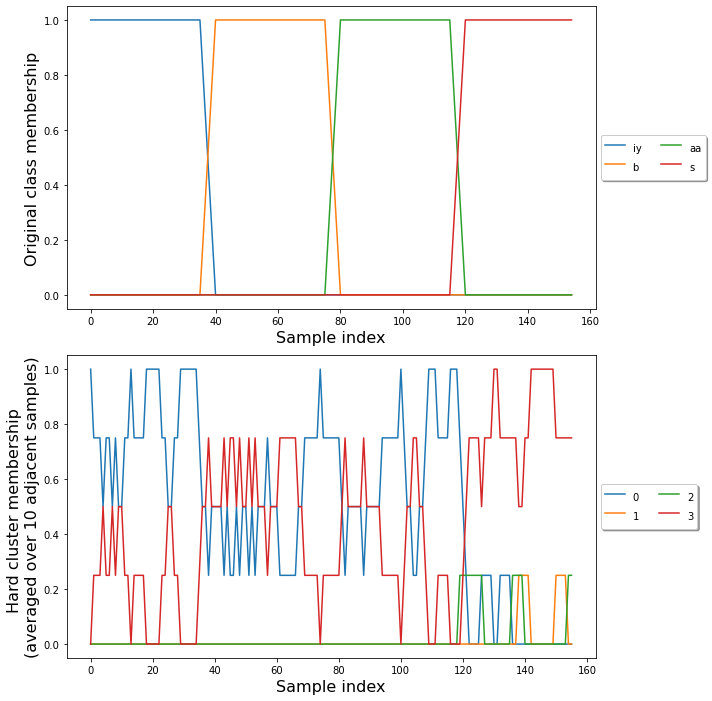

In [15]:
plot = Plot(10,10)
plot.add_new_assignment_plot(correct_assignments, labels=phonemes, xlabel="Sample index", ylabel="Original class membership")
plot.add_new_assignment_plot(assignments_kmeans, smoothness=4, xlabel="Sample index", ylabel="Hard cluster membership \n(averaged over 10 adjacent samples)")
plot.finalize()

## Experiment

In [9]:
def experiment(repetitions=5):
    params = {
        "method" : [Method.PRED],#[Method.OG_SIGNALS, Method.CENTROIDS, Method.SIMS, Method.PRED],
        "smart" : [False]#[True, False]
    }
    results = []
    for method in params["method"]:
        for smart in params["smart"]:
            NMIs = []
            print(f"Method: {method}, Smart start: {smart}")
            for _ in range(repetitions):
                km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)
                centroids, clusters = km.k_means(nb_clusters=n_classes, max_epochs=100, init_clusters="random", save=False)
                NMIs.append(NMI(km.cluster_to_assignment_repr(clusters), correct_assignments))
            print(f"mean {np.mean(NMIs)}")
            results.append( {
                "method": method,
                "smart": smart,
                "NMI": np.mean(NMIs)
            } )
    return results

results = experiment(3)
print(results)

Method: Method.PRED, Smart start: False
Running KMeans: 'random' initialization | Method.PRED method.
Epoch  0 # centroids: 4
Epoch  1 # centroids: 4
Epoch  2 # centroids: 4
Epoch  3 # centroids: 4
Epoch  4 # centroids: 4
Epoch  5 # centroids: 4
Epoch  6 # centroids: 4
Converged
Running KMeans: 'random' initialization | Method.PRED method.
Epoch  0 # centroids: 4
Epoch  1 # centroids: 4
Epoch  2 # centroids: 4
Epoch  3 # centroids: 4
Epoch  4 # centroids: 4
Epoch  5 # centroids: 4
Converged
Running KMeans: 'random' initialization | Method.PRED method.
Epoch  0 # centroids: 4
Epoch  1 # centroids: 4
Epoch  2 # centroids: 4
Epoch  3 # centroids: 4
Epoch  4 # centroids: 4
Epoch  5 # centroids: 4
Epoch  6 # centroids: 4
Epoch  7 # centroids: 4
Epoch  8 # centroids: 4
Epoch  9 # centroids: 4
Epoch  10 # centroids: 4
Epoch  11 # centroids: 4
Converged
mean 0.5323870976797318
[{'method': <Method.PRED: 4>, 'smart': False, 'NMI': 0.5323870976797318}]
